In [1]:
from nltk import bleu_score
import nltk
nltk.download('punkt')
import json
import pandas as pd
import sqlite3

[nltk_data] Downloading package punkt to /home/npateel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import spacy
nlp = spacy.load("en_core_web_md")


In [11]:
data = json.load(open('./qanta_train.json'))

In [16]:
conn = sqlite3.connect('qanta_train.sqlite')
c = conn.cursor()
c.execute("""
CREATE TABLE IF NOT EXISTS questions (text, answer, page, category, subcategory,
     tournament, difficulty, year, proto_id, qdb_id, dataset, qanta_id,
   tokenizations, first_sentence, gameplay, fold, i,
   last_sentence, shingle, nlp_question)
       """)
conn.commit()

In [3]:
import string
import re 
import numpy as np
import json
from rapidfuzz import process, fuzz
import unicodedata
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def get_exact_match(answers1, answers2):
    if type(answers1)==list:
        if len(answers1)==0:
            return 0
        # return np.max([get_exact_match(a, answers2) for a in answers1])
        # instead of np max we still fuzzy match between list and get the best possible result back from list.

        choice =  process.extractOne(normalize_answer(answers2), answer1, scorer=fuzz.ratio)
    elif type(answers2)==list:
        if len(answers2)==0:
            return 0
        choice =  process.extractOne(normalize_answer(answers1), answer2, scorer=fuzz.ratio)
    else:
        choice = fuzz.ratio(normalize_answer(answers1), normalize_answer(answers2))
        # the threshold is 63.3. Here we do miss 1-2 predictions 
        # very close to correct answers but this is the best possible result I could test on this dataset.
    return choice[1] >63.3 if type(choice)==tuple else choice >63.3
    
    
def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def remove_symbols(text):
        return re.sub(r'&lt.*', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    def unicode_to_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode()

    return unicode_to_ascii(white_space_fix(remove_articles(remove_punc(lower(remove_symbols(s))))))

def getlastsentence(s):
    sentences = nltk.sent_tokenize(s)
    return sentences[-1]


"""
The MIT License (MIT)

Copyright (c) 2016 Steven Samson

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import mmh3
from nltk import ngrams
import random


def generate_random_seeds(n, seed=5):
    random.seed(seed)
    return random.sample(range(1, n + 1), n)


def minhash_similarity(minhash_a, minhash_b):
    match_count = 0
    for a_item, b_item in zip(minhash_a, minhash_b):
        if a_item == b_item:
            match_count += 1
    return match_count / len(minhash_a)


class ShingledText:
    def __init__(self, text, random_seed=5, shingle_length=5, minhash_size=200):
        split_text = text.split()
        if len(split_text) < shingle_length:
            raise ValueError(u'input text is too short for specified shingle length of {}'.format(shingle_length))

        self.minhash = []
        self.shingles = ngrams(split_text, shingle_length)

        for hash_seed in generate_random_seeds(minhash_size, random_seed):
            min_value = float('inf')
            for shingle in ngrams(split_text, shingle_length):
                value = mmh3.hash(' '.join(shingle), hash_seed)
                min_value = min(min_value, value)
            self.minhash.append(min_value)

    def similarity(self, other_shingled_text):
        return minhash_similarity(self.minhash, other_shingled_text.minhash)




[nltk_data] Downloading package wordnet to /home/npateel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def extract_answer(s):   
    ans = s.split('[')[0].strip()
        # also tested a bunch of methods to increase accuracy, and found this one change.
        # We sub out what is in between two parnethesis, instead of removing everything after 
        # parenthesis thus making the match score quite bad for a few results. 
    ans = re.sub("[\(\[].*?[\)\]]", "", ans)
    return ans

In [12]:
questions = data['questions']
questions

[{'text': 'After this character relates a story about how he didn\'t know the proper way to use a wheelbarrow, he tells of how a captain dining with his father mistakenly rubbed his hands in a punch bowl.\xa0This "sea Prince of Wales" leaves his home by hiding out in a canoe near a coral reef, and he is mistakenly called "Hedgehog" by a character who offers him a ninetieth lay, a partner of Bildad named Peleg. A door is broken down in Mrs. Hussey\'s establishment after he locks himself in his room during a "Ramadan."\xa0He is first encountered in the Spouter-Inn where the landlord thinks he may be late because "he can\'t sell his head," and his coffin helps save the narrator after the ship he\'s on sinks.\xa0For 10 points, name this native of Rokovoko and savage companion of Ishmael in Moby-Dick.',
  'answer': 'Queequeg',
  'page': 'Queequeg',
  'category': 'Literature',
  'subcategory': 'American',
  'tournament': 'ACF Winter',
  'difficulty': 'College',
  'year': 2010,
  'proto_id': 

In [27]:
len(table)

112129

In [17]:
table = pd.DataFrame(questions)
drop_indices = np.random.choice(table.index,106000 , replace=False)
table = table.drop(drop_indices)
table['index'] = table.index
table['last_sentence'] = table.apply(lambda x: getlastsentence(x['text']), axis=1)
table = table[table['last_sentence'].map(lambda x : len(x.split()) > 3)]
table['shingle'] = table.apply(lambda x: ShingledText(x['last_sentence'], shingle_length=3), axis=1)
table['nlp_question'] = table.apply(lambda x: nlp(x['last_sentence']), axis=1)
table

,text,answer,page,category,subcategory,tournament,difficulty,year,proto_id,qdb_id,dataset,qanta_id,tokenizations,first_sentence,gameplay,fold,index,last_sentence,shingle,nlp_question
2,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,protobowl,2,"[[0, 134], [135, 262], [263, 398], [399, 518],...",This state's largest city endured an 1855 Rum ...,True,guesstrain,2,"For 10 points, name this state, home to Contin...",<__main__.ShingledText object at 0x7f3f72ef4730>,"(For, 10, points, ,, name, this, state, ,, hom..."
8,This period ended after the failure of the Dyl...,French {Third} Republic,French_Third_Republic,History,European,ACF Winter,College,2010,5476990eea23cca905506d59,NaN,protobowl,8,"[[0, 123], [124, 282], [283, 457], [458, 533],...",This period ended after the failure of the Dyl...,True,guesstrain,8,"For 10 points, identify this French government...",<__main__.ShingledText object at 0x7f3f72ef4700>,"(For, 10, points, ,, identify, this, French, g..."
40,One of this artist's most famous works was lat...,Andy Warhol [or Andrew Warhola],Andy_Warhol,Fine Arts,Art,ACF Winter,College,2010,5476990eea23cca905506d7c,NaN,protobowl,43,"[[0, 105], [106, 241], [242, 354], [355, 447],...",One of this artist's most famous works was lat...,True,guesstrain,40,"For 10 points, name this Pop artist best known...",<__main__.ShingledText object at 0x7f3f72ef47f0>,"(For, 10, points, ,, name, this, Pop, artist, ..."
48,Philip Pickett has suggested an interpretation...,{Brandenburg Concertos} [or {Brandenburg Conce...,Brandenburg_Concertos,Fine Arts,Music,ACF Winter,College,2010,5476990eea23cca905506d85,NaN,protobowl,52,"[[0, 189], [190, 366], [367, 532], [533, 658],...",Philip Pickett has suggested an interpretation...,True,guesstrain,48,"For 10 points, name this set of six concerti c...",<__main__.ShingledText object at 0x7f3f72ef4910>,"(For, 10, points, ,, name, this, set, of, six,..."
50,"Roderick Chisolm wrote about ""The Problem of"" ...",empiricism,Empiricism,Social Science,Philosophy,ACF Winter,College,2010,5476990eea23cca905506d88,NaN,protobowl,55,"[[0, 121], [122, 359], [360, 477], [478, 626],...","Roderick Chisolm wrote about ""The Problem of"" ...",True,buzztrain,50,"For 10 points, name this epistemological posit...",<__main__.ShingledText object at 0x7f3f72ef49a0>,"(For, 10, points, ,, name, this, epistemologic..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112861,"FTPE, answer the following related to the surp...",Tim Lincecum,Tim_Lincecum,Trash,None,Terrapin Invitational Tournament,regular_college,2011,None,66372.0,quizdb.org,184729,"[[0, 320]]","FTPE, answer the following related to the surp...",False,guesstrain,112861,"FTPE, answer the following related to the surp...",<__main__.ShingledText object at 0x7f3f6f0b3e50>,"(FTPE, ,, answer, the, following, related, to,..."
112867,This man's association with William E. Channin...,Charles Sumner,Charles_Sumner,Social Science,None,Terrapin Invitational Tournament,regular_college,2011,None,66366.0,quizdb.org,184735,"[[0, 205], [206, 520], [520, 691], [691, 940],...",This man's association with William E. Channin...,False,guesstrain,112867,"For 10 points, name this victim of a savage 18...",<__main__.ShingledText object at 0x7f3f6f0b3ee0>,"(For, 10, points, ,, name, this, victim, of, a..."
112896,In an episode of Star Trek: The Original Serie...,Abraham Lincoln,Abraham_Lincoln,Literature,None,Terrapin Invitational Tournament,regular_college,2011,None,66336.0,quizdb.org,184765,"[[0, 137], [138, 347], [348, 646], [647, 713],...",In an episode of Star Trek: The Original Serie...,False,guesstrain,112896,"For 10 points, name this U.S. President who is...",<__main__.ShingledText object at 0x7f3f6f0b3f70>,"(For, 10, points, ,, name, this, U.S., Preside..."
112918,This artist's Ecce Homo was commissioned with ...,Michelangelo Merisi da Caravaggio,Caravaggio,Fine Arts,None,E

In [14]:
table.columns[12]

'tokenizations'

In [5]:
table = pd.read_csv('qanta_train_table.csv', index_col=0)
drop_indices = np.random.choice(table.index,106000 , replace=False)
table = table.drop(drop_indices)
table

/tmp/ipykernel_10286/2778415259.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv('qanta_train_table.csv', index_col=0)


,text,answer,page,category,subcategory,tournament,difficulty,year,proto_id,qdb_id,dataset,qanta_id,tokenizations,first_sentence,gameplay,fold,index,last_sentence,shingle,nlp_question
14,Communist historiography blames the loss of th...,Battle of Mohacs,Battle_of_Mohács,History,World,ACF Winter,College,2010,5476990eea23cca905506d5f,NaN,protobowl,14,"[[0, 158], [159, 253], [254, 344], [345, 469],...",Communist historiography blames the loss of th...,True,guesstrain,14,"For 10 points, name this victory for Sulieman ...",<__main__.ShingledText object at 0x7f5154337130>,"For 10 points, name this victory for Sulieman ..."
40,One of this artist's most famous works was lat...,Andy Warhol [or Andrew Warhola],Andy_Warhol,Fine Arts,Art,ACF Winter,College,2010,5476990eea23cca905506d7c,NaN,protobowl,43,"[[0, 105], [106, 241], [242, 354], [355, 447],...",One of this artist's most famous works was lat...,True,guesstrain,40,"For 10 points, name this Pop artist best known...",<__main__.ShingledText object at 0x7f5154337fd0>,"For 10 points, name this Pop artist best known..."
60,This state contains an uplift zone that runs s...,Kansas,Kansas,Social Science,Geography,ACF Winter,College,2010,5476990eea23cca905506d93,NaN,protobowl,66,"[[0, 163], [164, 279], [280, 415], [416, 501],...",This state contains an uplift zone that runs s...,True,guesstrain,60,"For 10 points, name this state that contains c...",<__main__.ShingledText object at 0x7f51542f3b50>,"For 10 points, name this state that contains c..."
62,This figure appointed his greatest enemy as th...,General {Zod},General_Zod,Trash,Pop Culture,ACF Winter,College,2010,5476990eea23cca905506d96,NaN,protobowl,69,"[[0, 147], [148, 273], [274, 409], [410, 500],...",This figure appointed his greatest enemy as th...,True,guesstrain,62,"For 10 points, name this figure played by Tere...",<__main__.ShingledText object at 0x7f51542f3c70>,"For 10 points, name this figure played by Tere..."
63,One member of this group wrote tracts under th...,Levellers,Levellers,History,European,ACF Winter,College,2010,5476990eea23cca905506d98,NaN,protobowl,71,"[[0, 119], [120, 235], [236, 328], [329, 429],...",One member of this group wrote tracts under th...,True,guesstrain,63,"For 10 points, name this group of democratic a...",<__main__.ShingledText object at 0x7f51542f3d00>,"For 10 points, name this group of democratic a..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112870,"Morpholinos, synthetic uncharged nucleic acids...",RNAi or RNA interference,RNA_interference,Trash,NaN,Terrapin Invitational Tournament,regular_college,2011,NaN,66362.0,quizdb.org,184739,"[[0, 191], [192, 335], [336, 592], [593, 770]]","Morpholinos, synthetic uncharged nucleic acids...",False,guesstrain,112870,"Fire and Mello discovered, FTP what pathway of...",<__main__.ShingledText object at 0x7f510d055040>,"Fire and Mello discovered, FTP what pathway of..."
112890,One compound that performs this process consis...,hydrogenation,Hydrogenation,Science,NaN,Terrapin Invitational Tournament,regular_college,2011,NaN,66342.0,quizdb.org,184759,"[[0, 129], [130, 245], [246, 311], [312, 496],...",One compound that performs this process consis...,False,guesstrain,112890,"For 10 points, name this chemical process whic...",<__main__.ShingledText object at 0x7f510d055b80>,"For 10 points, name this chemical process whic..."
112898,One work by this man begins with the narrator ...,William Faulkner,William_Faulkner,Literature,NaN,Terrapin Invitational Tournament,regular_college,2011,NaN,66334.0,quizdb.org,184767,"[[0, 275], [276, 497], [498, 529], [530, 592],...",One work by this man begins with the narrator ...,False,guesstrain,112898,"For 10 points, name this American author of A ...",<__main__.ShingledText object at 0x7f510d015040>,"For 10 points, name this American author of A ..."
112902,Hostilities escalated during this event follow...,Red River Rebellion,Red_River_Rebellion,History,NaN,Terrapin Invitational Tournamen

In [18]:
productframe = table.merge(table, how='cross')
productframe = productframe.loc[productframe['index_x'] < productframe['index_y']]
productframe

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,...,dataset_y,qanta_id_y,tokenizations_y,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y
1,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,protobowl,8,"[[0, 123], [124, 282], [283, 457], [458, 533],...",This period ended after the failure of the Dyl...,True,guesstrain,8,"For 10 points, identify this French government...",<__main__.ShingledText object at 0x7f3f72ef4700>,"(For, 10, points, ,, identify, this, French, g..."
2,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,protobowl,43,"[[0, 105], [106, 241], [242, 354], [355, 447],...",One of this artist's most famous works was lat...,True,guesstrain,40,"For 10 points, name this Pop artist best known...",<__main__.ShingledText object at 0x7f3f72ef47f0>,"(For, 10, points, ,, name, this, Pop, artist, ..."
3,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,protobowl,52,"[[0, 189], [190, 366], [367, 532], [533, 658],...",Philip Pickett has suggested an interpretation...,True,guesstrain,48,"For 10 points, name this set of six concerti c...",<__main__.ShingledText object at 0x7f3f72ef4910>,"(For, 10, points, ,, name, this, set, of, six,..."
4,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,protobowl,55,"[[0, 121], [122, 359], [360, 477], [478, 626],...","Roderick Chisolm wrote about ""The Problem of"" ...",True,buzztrain,50,"For 10 points, name this epistemological posit...",<__main__.ShingledText object at 0x7f3f72ef49a0>,"(For, 10, points, ,, name, this, epistemologic..."
5,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,protobowl,86,"[[0, 64], [65, 190], [190, 410], [411, 574], [...",The speaker of this work asks its addressee to...,False,guesstrain,76,"For 10 points, identify this poem that depicts...",<__main__.ShingledText object at 0x7f3f72ef4a30>,"(For, 10, points, ,, identify, this, poem, tha..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47300002,This man's association with William E. Channin...,Charles Sumner,Charles_Sumner,Social Science,None,Terrapin Invitational Tournament,regular_college,2011,None,66366.0,...,quizdb.org,184887,"[[0, 166], [166, 260], [261, 389], [390, 548],...",This artist's Ecce Homo was commissioned with ...,False,guesstrain,112918,"For 10 points, identify this Chiaroscuro maste...",<__main__.ShingledText object at 0x7f3f6f074070>,"(For, 10, points, ,, identify, this, Chiaroscu..."
47300003,This man's association with William E. Channin...,Charles Sumner,Charles_Sumner,Social Science,None,Terrapin Invitational Tournament,regular_college,2011,None,66366.0,...,quizdb.org,187085,"[[0, 176], [177, 309], [310, 411], [412, 533],...",This book's final chapter chronicles how one o...,False,guesstrain,112923,"For 10 points, name this novel about Heathclif...",<__main__.ShingledText object at 0x7f3f6f0740d0>,"(For, 10, points, ,, name, this, novel, about,..."
47306881,In an episode of Star Trek: The Original Serie...,Abraham Lincoln,Abraham_Lincoln,Literature,None,Terrapin Invitational Tournament,regular_college,2011,None,66336.0,...,quizdb.org,184887,"[[0, 166], [166, 260], [261, 389], [390, 548],...",This artist's Ecce Homo was commissioned with ...,False,guesstrain,112918,"For 10 points, identify this Chiaroscuro maste...",<__main__.ShingledText object at 0x7f3f6f074070>,"(For, 10, points, ,, identify, this, Chiaroscu..."
47306882,In an episode of Star Trek: The Original Serie...,Abraham Lincoln,Abraham_Lincoln,Literature,None,Terrapin Invitational 

In [19]:
#productframe['nlp_question'] = productframe.apply(lambda x: x['nlp_question_x'].similarity(x['nlp_question_y']), axis=1)
productframe['shingle_similarity'] = productframe.apply(lambda x: x['shingle_x'].similarity(x['shingle_y']), axis=1)
productframe

    

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,...,qanta_id_y,tokenizations_y,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y,shingle_similarity
1,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,8,"[[0, 123], [124, 282], [283, 457], [458, 533],...",This period ended after the failure of the Dyl...,True,guesstrain,8,"For 10 points, identify this French government...",<__main__.ShingledText object at 0x7f3f72ef4700>,"(For, 10, points, ,, identify, this, French, g...",0.035
2,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,43,"[[0, 105], [106, 241], [242, 354], [355, 447],...",One of this artist's most famous works was lat...,True,guesstrain,40,"For 10 points, name this Pop artist best known...",<__main__.ShingledText object at 0x7f3f72ef47f0>,"(For, 10, points, ,, name, this, Pop, artist, ...",0.120
3,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,52,"[[0, 189], [190, 366], [367, 532], [533, 658],...",Philip Pickett has suggested an interpretation...,True,guesstrain,48,"For 10 points, name this set of six concerti c...",<__main__.ShingledText object at 0x7f3f72ef4910>,"(For, 10, points, ,, name, this, set, of, six,...",0.105
4,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,55,"[[0, 121], [122, 359], [360, 477], [478, 626],...","Roderick Chisolm wrote about ""The Problem of"" ...",True,buzztrain,50,"For 10 points, name this epistemological posit...",<__main__.ShingledText object at 0x7f3f72ef49a0>,"(For, 10, points, ,, name, this, epistemologic...",0.090
5,This state's largest city endured an 1855 Rum ...,Maine,Maine,History,American,ACF Winter,College,2010,5476990eea23cca905506d53,NaN,...,86,"[[0, 64], [65, 190], [190, 410], [411, 574], [...",The speaker of this work asks its addressee to...,False,guesstrain,76,"For 10 points, identify this poem that depicts...",<__main__.ShingledText object at 0x7f3f72ef4a30>,"(For, 10, points, ,, identify, this, poem, tha...",0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47300002,This man's association with William E. Channin...,Charles Sumner,Charles_Sumner,Social Science,None,Terrapin Invitational Tournament,regular_college,2011,None,66366.0,...,184887,"[[0, 166], [166, 260], [261, 389], [390, 548],...",This artist's Ecce Homo was commissioned with ...,False,guesstrain,112918,"For 10 points, identify this Chiaroscuro maste...",<__main__.ShingledText object at 0x7f3f6f074070>,"(For, 10, points, ,, identify, this, Chiaroscu...",0.025
47300003,This man's association with William E. Channin...,Charles Sumner,Charles_Sumner,Social Science,None,Terrapin Invitational Tournament,regular_college,2011,None,66366.0,...,187085,"[[0, 176], [177, 309], [310, 411], [412, 533],...",This book's final chapter chronicles how one o...,False,guesstrain,112923,"For 10 points, name this novel about Heathclif...",<__main__.ShingledText object at 0x7f3f6f0740d0>,"(For, 10, points, ,, name, this, novel, about,...",0.140
47306881,In an episode of Star Trek: The Original Serie...,Abraham Lincoln,Abraham_Lincoln,Literature,None,Terrapin Invitational Tournament,regular_college,2011,None,66336.0,...,184887,"[[0, 166], [166, 260], [261, 389], [390, 548],...",This artist's Ecce Homo was commissioned with ...,False,guesstrain,112918,"For 10 points, identify this Chiaroscuro maste...",<__main__.ShingledText object at 0x7f3f6f074070>,"(For, 10, points, ,, identify, this, Chiaroscu...",0.010
47306882,In an episode of Star Trek: The Original Serie...,Abraham Lincoln,Abraham_Lincoln,Literature,None,Terrapin Invitational Tournament,regular_college

<AxesSubplot:>

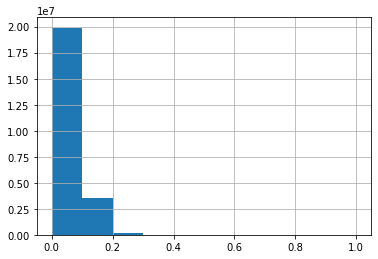

In [20]:
productframe['shingle_similarity'].hist()

In [21]:
similar = productframe.sort_values(by=['shingle_similarity'], ascending=False)

In [22]:

similar['answer_x_extractred'] = similar['answer_x'].apply(extract_answer)
similar['answer_y_extracted'] = similar['answer_y'].apply(extract_answer)
similar

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,...,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y,shingle_similarity,answer_x_extractred,answer_y_extracted
29295719,One ruler of this empire referred to by some a...,Mauryan Empire [Accept Mauryan Dynasty.],Maurya_Empire,History,None,Harvard Fall Tournament VII,HS,2012,5476da9dea23cca90551b171,NaN,...,One ruler of this empire referred to by some a...,True,guesstrain,80936,"For 10 points, identify this Indian dynasty fo...",<__main__.ShingledText object at 0x7f3f701b6b80>,"(For, 10, points, ,, identify, this, Indian, d...",1.0,Mauryan Empire,Mauryan Empire
12088451,One character in this novel has a habit of eat...,One {Hundred Years} of {Solitude} [or {Cien Añ...,One_Hundred_Years_of_Solitude,Literature,None,HFT,HS,2009,54769931ea23cca90550e49f,NaN,...,One character in this novel has a habit of eat...,True,guesstrain,33249,"For 10 points, name this novel set in Macondo ...",<__main__.ShingledText object at 0x7f3f71b318b0>,"(For, 10, points, ,, name, this, novel, set, i...",1.0,One {Hundred Years} of {Solitude},One {Hundred Years} of {Solitude}
6618787,"The aria ""Dies Bildnis"" is sung by this opera'...",The {Magic Flute} [or Die {Zauberflöte}],The_Magic_Flute,Fine Arts,None,HSAPQ Tournament 15,HS,2011,5476992dea23cca90550abcf,NaN,...,"The aria ""Dies Bildnis"" is sung by this opera'...",True,guesstrain,18386,"For 10 points, name this Wolfgang Amadeus Moza...",<__main__.ShingledText object at 0x7f3f722ffdc0>,"(For, 10, points, ,, name, this, Wolfgang, Ama...",1.0,The {Magic Flute},The Magic {Flute}
34421971,The Rebellion of the Three Guards occurred in ...,China,China,History,World,BISB,HS,2013,58b0b80070b91540957183d0,NaN,...,The Rebellion of the Three Guards occurred in ...,False,guesstrain,103908,"For 10 points, name this nation whose prehisto...",<__main__.ShingledText object at 0x7f3f6f5099d0>,"(For, 10, points, ,, name, this, nation, whose...",1.0,China,China
17001903,"This man's Jacob House, which was designed on ...",Frank Lloyd Wright,Frank_Lloyd_Wright,Fine Arts,Other,Collegiate Novice,College,2013,5476a1f6ea23cca905511bce,NaN,...,This man designed skyscrapers including the mi...,True,guesstrain,63635,"For 10 points, name this American architect of...",<__main__.ShingledText object at 0x7f3f70a8b790>,"(For, 10, points, ,, name, this, American, arc...",1.0,Frank Lloyd Wright,Frank Lloyd {Wright}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4060484,He ended his life as king of Illyricum and wen...,Cadmus,Cadmus,Social Science,Religion/Mythology,ACF Regionals,College,2003,54769911ea23cca9055092b7,NaN,...,This musician quoted the hymn Gaudeamus Igitur...,True,guesstrain,30059,"For 10 points, name this German composer known...",<__main__.ShingledText object at 0x7f3f71cb4550>,"(For, 10, points, ,, name, this, German, compo...",0.0,Cadmus,Johannes {Brahms}
10206848,The third movement of this man's third symphon...,Aaron {Copland},Aaron_Copland,Fine Arts,None,Chipola Lit + Fine Arts,College,2009,5476992fea23cca90550d1b5,NaN,...,Hermann Usener published a massive compilation...,True,guesstrain,86880,"For 10 points, name this Greek philosopher who...",<__main__.ShingledText object at 0x7f3f6fe665e0>,"(For, 10, points, ,, name, this, Greek, philos...",0.0,Aaron {Copland},Epicurus
4060483,He ended his life as king of Illyricum and wen...,Cadmus,Cadmus,Social Science,Religion/Mythology,ACF Regionals,College,2003,54769911ea23cca9055092b7,NaN,...,This woman was the mother of Henry VIII's firs...,True,guesstrain,30054,"For 10 points, name this queen of Castile who ...",<__main__.ShingledText object at 0x7f3f71cb44c0>,"(For, 10, points, ,, name, this, queen, of, Ca...",0.0,Cadmus,{Isabella} I of Castile
4060482,He ended his life as king of Illyricum and wen...,Cadmus,Cadmus,Social Science,Religion/Mythology,ACF Regionals,College,2003,54769911ea23cca9055

In [23]:
pd.set_option('display.max_columns', None)
similar

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,dataset_x,qanta_id_x,tokenizations_x,first_sentence_x,gameplay_x,fold_x,index_x,last_sentence_x,shingle_x,nlp_question_x,text_y,answer_y,page_y,category_y,subcategory_y,tournament_y,difficulty_y,year_y,proto_id_y,qdb_id_y,dataset_y,qanta_id_y,tokenizations_y,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y,shingle_similarity,answer_x_extractred,answer_y_extracted
29295719,One ruler of this empire referred to by some a...,Mauryan Empire [Accept Mauryan Dynasty.],Maurya_Empire,History,None,Harvard Fall Tournament VII,HS,2012,5476da9dea23cca90551b171,NaN,protobowl,82290,"[[0, 117], [118, 304], [305, 465], [466, 583],...",One ruler of this empire referred to by some a...,True,guesstrain,69657,"For 10 points, identify this Indian dynasty fo...",<__main__.ShingledText object at 0x7f3f70747790>,"(For, 10, points, ,, identify, this, Indian, d...",One ruler of this empire referred to by some a...,Mauryan Empire [Accept Mauryan Dynasty.],Maurya_Empire,History,World,Harvard Fall Tournament,HS,2012,58b0b7e670b9154095717e42,NaN,protobowl,96341,"[[0, 117], [118, 304], [305, 465], [466, 583],...",One ruler of this empire referred to by some a...,True,guesstrain,80936,"For 10 points, identify this Indian dynasty fo...",<__main__.ShingledText object at 0x7f3f701b6b80>,"(For, 10, points, ,, identify, this, Indian, d...",1.0,Mauryan Empire,Mauryan Empire
12088451,One character in this novel has a habit of eat...,One {Hundred Years} of {Solitude} [or {Cien Añ...,One_Hundred_Years_of_Solitude,Literature,None,HFT,HS,2009,54769931ea23cca90550e49f,NaN,protobowl,30540,"[[0, 88], [89, 186], [187, 293], [294, 425], [...",One character in this novel has a habit of eat...,True,guesstrain,28139,"For 10 points, name this novel set in Macondo ...",<__main__.ShingledText object at 0x7f3f71db6280>,"(For, 10, points, ,, name, this, novel, set, i...",One character in this novel has a habit of eat...,One {Hundred Years} of {Solitude} [or {Cien Añ...,One_Hundred_Years_of_Solitude,Literature,None,HFT,HS,2009,54769932ea23cca90550f9df,NaN,protobowl,35980,"[[0, 88], [89, 186], [187, 293], [294, 425], [...",One character in this novel has a habit of eat...,True,guesstrain,33249,"For 10 points, name this novel set in Macondo ...",<__main__.ShingledText object at 0x7f3f71b318b0>,"(For, 10, points, ,, name, this, novel, set, i...",1.0,One {Hundred Years} of {Solitude},One {Hundred Years} of {Solitude}
6618787,"The aria ""Dies Bildnis"" is sung by this opera'...",The {Magic Flute} [or Die {Zauberflöte}],The_Magic_Flute,Fine Arts,None,HSAPQ Tournament 15,HS,2011,5476992dea23cca90550abcf,NaN,protobowl,15997,"[[0, 151], [152, 215], [216, 425], [426, 539]]","The aria ""Dies Bildnis"" is sung by this opera'...",True,guesstrain,14670,"For 10 points, name this Wolfgang Amadeus Moza...",<__main__.ShingledText object at 0x7f3f7248cc10>,"(For, 10, points, ,, name, this, Wolfgang, Ama...","The aria ""Dies Bildnis"" is sung by this opera'...",The Magic {Flute} [or {Die Zauberflöte}],The_Magic_Flute,Fine Arts,None,HSAPQ Tournament 15,HS,2011,5476992eea23cca90550bb21,NaN,protobowl,19919,"[[0, 151], [152, 215], [216, 425], [426, 539]]","The aria ""Dies Bildnis"" is sung by this opera'...",True,guesstrain,18386,"For 10 points, name this Wolfgang Amadeus Moza...",<__main__.ShingledText object at 0x7f3f722ffdc0>,"(For, 10, points, ,, name, this, Wolfgang, Ama...",1.0,The {Magic Flute},The Magic {Flute}
34421971,The Rebellion of the Three Guards occurred in ...,China,China,History,World,BISB,HS,2013,58b0b80070b91540957183d0,NaN,protobowl,97760,"[[0, 133], [134, 220], [221, 278], [279, 400],...",The Rebellion of the Three Guards occurred in ...,True,guesstrain,82019,"For 10 points, name this nation whose prehisto...",<__main__.ShingledText object at 0x7f3f700f4160>,"(For, 10, points, ,, name, this, nation, whose...",The Rebellion of the Three Guards occurred

In [24]:
similar['answer_similarity'] = similar.apply(lambda x: get_exact_match(x['answer_x_extractred'], x['answer_y_extracted']), axis=1)

In [25]:
similar

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,dataset_x,qanta_id_x,tokenizations_x,first_sentence_x,gameplay_x,fold_x,index_x,last_sentence_x,shingle_x,nlp_question_x,text_y,answer_y,page_y,category_y,subcategory_y,tournament_y,difficulty_y,year_y,proto_id_y,qdb_id_y,dataset_y,qanta_id_y,tokenizations_y,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y,shingle_similarity,answer_x_extractred,answer_y_extracted,answer_similarity
29295719,One ruler of this empire referred to by some a...,Mauryan Empire [Accept Mauryan Dynasty.],Maurya_Empire,History,None,Harvard Fall Tournament VII,HS,2012,5476da9dea23cca90551b171,NaN,protobowl,82290,"[[0, 117], [118, 304], [305, 465], [466, 583],...",One ruler of this empire referred to by some a...,True,guesstrain,69657,"For 10 points, identify this Indian dynasty fo...",<__main__.ShingledText object at 0x7f3f70747790>,"(For, 10, points, ,, identify, this, Indian, d...",One ruler of this empire referred to by some a...,Mauryan Empire [Accept Mauryan Dynasty.],Maurya_Empire,History,World,Harvard Fall Tournament,HS,2012,58b0b7e670b9154095717e42,NaN,protobowl,96341,"[[0, 117], [118, 304], [305, 465], [466, 583],...",One ruler of this empire referred to by some a...,True,guesstrain,80936,"For 10 points, identify this Indian dynasty fo...",<__main__.ShingledText object at 0x7f3f701b6b80>,"(For, 10, points, ,, identify, this, Indian, d...",1.0,Mauryan Empire,Mauryan Empire,True
12088451,One character in this novel has a habit of eat...,One {Hundred Years} of {Solitude} [or {Cien Añ...,One_Hundred_Years_of_Solitude,Literature,None,HFT,HS,2009,54769931ea23cca90550e49f,NaN,protobowl,30540,"[[0, 88], [89, 186], [187, 293], [294, 425], [...",One character in this novel has a habit of eat...,True,guesstrain,28139,"For 10 points, name this novel set in Macondo ...",<__main__.ShingledText object at 0x7f3f71db6280>,"(For, 10, points, ,, name, this, novel, set, i...",One character in this novel has a habit of eat...,One {Hundred Years} of {Solitude} [or {Cien Añ...,One_Hundred_Years_of_Solitude,Literature,None,HFT,HS,2009,54769932ea23cca90550f9df,NaN,protobowl,35980,"[[0, 88], [89, 186], [187, 293], [294, 425], [...",One character in this novel has a habit of eat...,True,guesstrain,33249,"For 10 points, name this novel set in Macondo ...",<__main__.ShingledText object at 0x7f3f71b318b0>,"(For, 10, points, ,, name, this, novel, set, i...",1.0,One {Hundred Years} of {Solitude},One {Hundred Years} of {Solitude},True
6618787,"The aria ""Dies Bildnis"" is sung by this opera'...",The {Magic Flute} [or Die {Zauberflöte}],The_Magic_Flute,Fine Arts,None,HSAPQ Tournament 15,HS,2011,5476992dea23cca90550abcf,NaN,protobowl,15997,"[[0, 151], [152, 215], [216, 425], [426, 539]]","The aria ""Dies Bildnis"" is sung by this opera'...",True,guesstrain,14670,"For 10 points, name this Wolfgang Amadeus Moza...",<__main__.ShingledText object at 0x7f3f7248cc10>,"(For, 10, points, ,, name, this, Wolfgang, Ama...","The aria ""Dies Bildnis"" is sung by this opera'...",The Magic {Flute} [or {Die Zauberflöte}],The_Magic_Flute,Fine Arts,None,HSAPQ Tournament 15,HS,2011,5476992eea23cca90550bb21,NaN,protobowl,19919,"[[0, 151], [152, 215], [216, 425], [426, 539]]","The aria ""Dies Bildnis"" is sung by this opera'...",True,guesstrain,18386,"For 10 points, name this Wolfgang Amadeus Moza...",<__main__.ShingledText object at 0x7f3f722ffdc0>,"(For, 10, points, ,, name, this, Wolfgang, Ama...",1.0,The {Magic Flute},The Magic {Flute},True
34421971,The Rebellion of the Three Guards occurred in ...,China,China,History,World,BISB,HS,2013,58b0b80070b91540957183d0,NaN,protobowl,97760,"[[0, 133], [134, 220], [221, 278], [279, 400],...",The Rebellion of the Three Guards occurred in ...,True,guesstrain,82019,"For 10 points, name this nation whose prehisto...",<__main__.ShingledText object at 0x7f3f700f4160>,"(For, 10, points, ,, name, this, nation, whose...",The Rebel

In [27]:
#diff_questions = similar.loc[(similar['year_x'] != similar['year_y']) & (~similar['answer_similarity']) & (similar['nlp_question'] > 0.95)]
diff_questions = similar.loc[(similar['year_x'] != similar['year_y']) & (~similar['answer_similarity'])]
#diff_questions = similar.loc[~(similar['answer_similarity'])]
diff_questions

,text_x,answer_x,page_x,category_x,subcategory_x,tournament_x,difficulty_x,year_x,proto_id_x,qdb_id_x,dataset_x,qanta_id_x,tokenizations_x,first_sentence_x,gameplay_x,fold_x,index_x,last_sentence_x,shingle_x,nlp_question_x,text_y,answer_y,page_y,category_y,subcategory_y,tournament_y,difficulty_y,year_y,proto_id_y,qdb_id_y,dataset_y,qanta_id_y,tokenizations_y,first_sentence_y,gameplay_y,fold_y,index_y,last_sentence_y,shingle_y,nlp_question_y,shingle_similarity,answer_x_extractred,answer_y_extracted,answer_similarity
12859304,This composer wrote a tone poem in which the E...,Jean {Sibelius} ({sey}-{BAIL}-{ay}-{us}),Jean_Sibelius,Fine Arts,None,HSAPQ Tournament 11,HS,2009,54769932ea23cca90550ec42,NaN,protobowl,32495,"[[0, 103], [104, 202], [203, 378], [379, 413],...",This composer wrote a tone poem in which the E...,True,guesstrain,30003,"For 10 points, name this composer of Finlandia.",<__main__.ShingledText object at 0x7f3f71cb4280>,"(For, 10, points, ,, name, this, composer, of,...",One work by this composer includes the section...,George Frideric Händel,George_Frideric_Handel,Fine Arts,Music,Collaborative MS Tournament,MS,2013,5476a1ebea23cca905511ab5,NaN,protobowl,44343,"[[0, 78], [79, 116], [117, 230], [231, 363], [...",One work by this composer includes the section...,True,buzztrain,40138,"For 10 points, name this composer of Messiah.",<__main__.ShingledText object at 0x7f3f71768040>,"(For, 10, points, ,, name, this, composer, of,...",0.775,Jean {Sibelius},George Frideric Händel,False
12861900,This composer wrote a tone poem in which the E...,Jean {Sibelius} ({sey}-{BAIL}-{ay}-{us}),Jean_Sibelius,Fine Arts,None,HSAPQ Tournament 11,HS,2009,54769932ea23cca90550ec42,NaN,protobowl,32495,"[[0, 103], [104, 202], [203, 378], [379, 413],...",This composer wrote a tone poem in which the E...,True,guesstrain,30003,"For 10 points, name this composer of Finlandia.",<__main__.ShingledText object at 0x7f3f71cb4280>,"(For, 10, points, ,, name, this, composer, of,...",This composer's Zadok the Priest is an anthem ...,George Frederick Handel,George_Frideric_Handel,Fine Arts,Auditory,SCOP Novice,HS,2013,58b0b81470b915409571879c,NaN,protobowl,98731,"[[0, 92], [93, 289], [290, 377], [378, 423]]",This composer's Zadok the Priest is an anthem ...,True,guesstrain,82689,"For 10 points, name this composer of Messiah.",<__main__.ShingledText object at 0x7f3f700b3b80>,"(For, 10, points, ,, name, this, composer, of,...",0.775,Jean {Sibelius},George Frederick Handel,False
8271100,This man's sayings were documented in the Agam...,{Mahavira} [or {Prince Vardhamana}],Mahavira,Religion,None,St. Anselms and Torrey Pines,HS,2011,5476992eea23cca90550bc28,NaN,protobowl,20182,"[[0, 171], [172, 245], [246, 387], [388, 518],...",This man's sayings were documented in the Agam...,True,guesstrain,18625,"For 10 points, name this man, the founder of J...",<__main__.ShingledText object at 0x7f3f722be550>,"(For, 10, points, ,, name, this, man, ,, the, ...",This man claimed that Hong Kong was one of the...,Kim Dotcom [or Kim Schmitz; or Kimble; or Kim ...,Kim_Dotcom,Trash,Norse,WIT,College,2013,5476a235ea23cca9055121c0,NaN,protobowl,46145,"[[0, 87], [88, 230], [231, 330], [331, 389], [...",This man claimed that Hong Kong was one of the...,True,guesstrain,41690,"For 10 points, name this man, the founder of M...",<__main__.ShingledText object at 0x7f3f716a3310>,"(For, 10, points, ,, name, this, man, ,, the, ...",0.770,{Mahavira},Kim Dotcom,False
15868020,"Although he is not Sun Tzu, this man wrote a v...",Niccolo {Machiavelli},Niccolò_Machiavelli,Philosophy,Norse,Collaborative MS Tournament,MS,2011,5476a08cea23cca905510c70,NaN,protobowl,40691,"[[0, 71], [72, 135], [136, 303], [304, 368], [...","Although he is not Sun Tzu, this man wrote a v...",True,guesstrain,37433,"For 10 points, name this author of The Prince.",<__main__.ShingledText object at 0x7f3f718f1c10>,"(For, 10, points, ,, name, this, author, of, T...",This author wrote about an ape behaving like a...,Franz Kaf